In [32]:
import numpy as np


def env():
    # 定义系统的A和B矩阵
    A = np.array([[0, 10], 
                  [-10, 0]])  # 系统矩阵 A
    B = np.array([[0],
                  [1]])  # 系统矩阵 B
    return A, B
    
# 时间间隔，用于环境中的数据采样
def init_time_intervals(n, m):
    delta_t = 0.1
    return np.arange(0, (n*(n+1)/2+n*m+2)*delta_t, delta_t)  # 样本时间间隔
    
def init_state():
    # 初始化算法参数
    
    n = 2  # 系统状态维度
    m = 1  # 控制输入维度
    
    # 定义初始化K矩阵
    K_i_0 = np.zeros((m, n))
    #print(x_0)
    
    # 初始矩阵 P_i^j 
    P_i_j = np.eye(n)  
    return n, m, K_i_0, P_i_j



In [33]:
# delta_t = 0.1
# n = 4
# m = 2
# array = np.arange(0, (n*(n+1)/2+n*m+1)*delta_t, delta_t)
# print(array.size )

In [34]:

# 画出 x_data 的图，所有行放在一张图里
from matplotlib import pyplot as plt


def plot_x_data(x_data):
    print(f"x_data.shape:{x_data.shape}")
    plt.figure(figsize=(10, 6))
    for i in range(x_data.shape[0]):
        plt.plot(range(x_data.shape[1]), x_data[i, :], label=f'x_data row {i + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('x_data Plot')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [35]:
import numpy as np
def integrate_2d_array(x_i, x_i_d, delta_t):
    return x_i + delta_t * x_i_d

# 采样
def sample(n, m, K):
    # 获取A，B
    A, B = env()

    # 时间间隔，用于环境中的数据采样
    time_intervals = init_time_intervals(n, m)

    # 随机初始化状态x_i
    seed = 1
    x_i = np.random.rand(n, 1)   
    # x_i = np.array([[1],
    #                 [2],
    #                 [3],
    #                 [4]])
    # 数据收集初始化，存放x_i的每个采样状态，用于计算 Ψ_i、Φ_i、Π_i 矩阵
    x_data = np.zeros((n, 1))
    xi_data = np.zeros((m, 1))

    # 采样循环
    for t in range(0, len(time_intervals)-1):
        # 生成一个 大小2x1 的 Gaussian 噪声数组
        gaussian_noise = np.random.normal(0, 1, (m, 1))
        # print(gaussian_noise)

        # 计算控制输入 ξ_i,大小m*1和下一个状态的导数x_i_d,大小n*1
        xi_i = K @ x_i + gaussian_noise
        x_i_d = A @ x_i + B @ xi_i

        # 求下一个状态,n*1
        delta_t = time_intervals[t + 1] - time_intervals[t]
        x_i_next = integrate_2d_array(x_i, x_i_d, delta_t)

        # 收集状态,添加一列数据
        x_data = np.hstack((x_data, x_i))
        xi_data = np.hstack((xi_data, xi_i))
        # print("------------")
        # print(x_data)
        # 更新至下一个状态
        x_i = x_i_next
        #print(x_i)

    # 删除掉初始时全为0的第一列元素
    x_data = np.delete(x_data, 0, axis=1) 
    xi_data = np.delete(xi_data, 0, axis=1) 
    
    # print(x_data.shape) 
    # plot_x_data(x_data)
    return x_data, xi_data
# n = 4
# m = 2
# time_intervals = np.arange(0, n*(n+1)/2+n*m)  # 样本时间间隔
# print(time_intervals)

In [ ]:
    
# 实现根据给定公式计算 x- 的函数
def compute_x_bar(n, x):
    x_bar = []
    for i in range(n):
        for j in range(i, n):
            if i == j:
                x_bar.append(x[i, 0] ** 2)
            else:
                x_bar.append(2 * x[i, 0] * x[j, 0])
    return np.array(x_bar).reshape(n * (n + 1) // 2, 1)

def integrate_2d_array_2(x, delta_t):
    return delta_t*x

# 计算Ψ_i矩阵
def get_Psi_i(n, x_data):
    # 初始化Ψ_i矩阵
    Psi_i = np.zeros((n*n, 1))

    # 如果是按开始时间算就是0~17列，如果是按结束时间算就是1~18列
    column = x_data.shape[1] - 1
    for t in range(column):
        x_i = x_data[:, t] # 提出一列元素变为一维数组
        x_i = x_i.reshape(-1,1) # 转为二维数组4*1
        #print(x_i.shape)
        Psi_i = np.hstack((Psi_i, np.kron(x_i, x_i)))
    Psi_i = np.delete(Psi_i, 0, axis=1) # 删除掉初始时全为0的第一列元素
    Psi_i = Psi_i.T
    print(f"Psi_i.shape{Psi_i.shape}")
    return Psi_i

# 计算Φ_i, 和 Π_i 矩阵，从而获得Γ_i 矩阵
def get_Gamma(n, m, x_data, xi_data, K):
    # # 采样
    # x_data, xi_data = sample(n, m, K)
    
    # 时间间隔，用于环境中的数据采样
    time_intervals = init_time_intervals(n, m)

    # 定义 Φ_i, 和 Π_i 矩阵
    Phi_i = np.zeros((n*(n+1)//2, 1))
    Pi_i = np.zeros((n*m, 1))

    # # 计算Ψ_i矩阵
    # Psi_i = get_Psi_i(n, x_data)

    # 计算Φ_i矩阵
    column = x_data.shape[1]
    for t in range(1,column):
        delta_t = time_intervals[t] - time_intervals[t-1]
        x_i = x_data[:, t] # 提出一列元素变为一维数组
        x_i = x_i.reshape(-1,1) # 转为二维数组4*1
        x_bar = compute_x_bar(n, x_i) # 求x-
        x_bar_intergral = integrate_2d_array_2(x_bar, delta_t)
        Phi_i = np.hstack((Phi_i, x_bar_intergral))
    Phi_i = np.delete(Phi_i, 0, axis=1) # 删除掉初始时全为0的第一列元素
    Phi_i = Phi_i.T
    print(f"Phi_i.shape:{Phi_i.shape}") #18*10

    # 计算Π_i 矩阵
    for t in range(1,column):
        delta_t = time_intervals[t] - time_intervals[t-1]
        x_i = x_data[:, t] # 提出一列元素变为一维数组
        x_i = x_i.reshape(-1,1) # 转为二维数组4*1
        xi_i = xi_data[:, t] # 提出一列元素变为一维数组
        xi_i = xi_i.reshape(-1,1) # 转为二维数组2*1
        x_Pi = np.kron(xi_i, x_i)
        x_Pi_intergral = integrate_2d_array_2(x_Pi, delta_t) # 求积分
        Pi_i = np.hstack((Pi_i, x_Pi_intergral))
    Pi_i = np.delete(Pi_i, 0, axis=1) # 删除掉初始时全为0的第一列元素
    Pi_i = Pi_i.T
    print(f"Pi_i.shape:{Pi_i.shape}") #18*8


    # 计算 Γ_i 矩阵
    # print(Phi_i.shape)
    # print(Pi_i.shape)
    Gamma_i = np.hstack((Phi_i, 2 * Pi_i))
    # print(Gamma_i.shape)
    return Gamma_i



In [37]:
# n = 4
# m = 2
# K_i_0 = np.zeros((m, n))
# sample(n, m, K_i_0)

In [38]:


# 检查矩阵 Γ_i 是否满足秩条件
def check_Gamma(n, m, Gamma_i):
    if np.linalg.matrix_rank(Gamma_i) >= (n * (n + 1) // 2) + n * m:
        print("Gamma_i：{Gamma_i} 满足秩条件。")
    else:
        print("Gamma_i：{Gamma_i} 不满足秩条件。")

# 检查 P 矩阵是否符合公式 A.T * P + P * A - P * B * B.T * P + Q = 0
def check_P_matrix(Q, P, epsilon):
    # 获取A，B
    A, B = env()
    left_side = A.T @ P + P @ A - P @ B @ B.T @ P + Q
    # print(f"left_side:{left_side}")
    # right_side = np.zeros(left_side.shape)
    is_valid_p = np.all(left_side < epsilon)
    # is_valid_p = np.allclose(left_side, np.zeros_like(left_side))
    print("P 矩阵是否符合公式: ", is_valid_p)



In [39]:

def recover_matrices(n, m, vecs_h, vec_k):
    # 还原 H_i^j 矩阵
    h_matrix = np.zeros((n, n))
    index = 0
    for i in range(n):
        for j in range(i, n):
            if i == j:
                h_matrix[i, j] = vecs_h[index]
            else:
                h_matrix[i, j] = vecs_h[index]
                h_matrix[j, i] = vecs_h[index]
            index += 1

    # 还原 K_i^j 矩阵
    k_matrix = np.zeros((m, n))
    index = 0
    for i in range(m):
        for j in range(i, n):
                k_matrix[i, j] = vec_k[index]
                index += 1
    return h_matrix, k_matrix

# 计算 Hj 和 Kj 的辅助函数,对应公式（10）
def compute_H_K(n, m, gamma_i, psi_i, p_i):
    # 计算 (Gamma_i^T * Gamma_i)^(-1)
    gamma_t_gamma = np.dot(gamma_i.T, gamma_i)
    gamma_t_gamma_inv = np.linalg.inv(gamma_t_gamma)
    
    # 计算 Gamma_i^T * Psi_i
    gamma_t_psi = np.dot(gamma_i.T, psi_i)
    
    # 将 P_i 向量化
    p_i_vec = p_i.flatten()
    
    # 计算结果向量
    result = np.dot(gamma_t_gamma_inv, np.dot(gamma_t_psi, p_i_vec))
    # print(result.shape)
    # 提取 vecs(H_i^j) 和 vec(K_i^j)
    size_h = result.size - n * m
    vecs_h = result[:size_h]
    vec_k = result[size_h:]
    # print(vecs_h.shape)
    # print(vec_k.shape)
    return recover_matrices(n, m, vecs_h, vec_k)



# 定义更新 P_i_j 的函数
def update_P(P_i_j, H_i_j, Q, K_i_j, delta_j):
    return P_i_j + delta_j * (H_i_j + Q - (K_i_j.T @ K_i_j))



In [40]:

# 主循环进行算法迭代
def solve_K(max_iters=1000000000):

    n, m, K_i_j, P_i_j = init_state()
    # 初始化 P_i_j_0, K_i_j_prev,和迭代计数器 j,k
    P_i_j_0 = P_i_j
    j = 0
    k = 1

    # 控制算法的参数初始化
    epsilon = 1
    Q = np.eye(n)

    # 采样
    x_data, xi_data = sample(n, m, K_i_j)
    plot_x_data(x_data)
    # plot_x_data(xi_data)
    #获取相关矩阵信息
    Psi_i = get_Psi_i(n, x_data)
    Gamma_i = get_Gamma(n, m, x_data, xi_data, K_i_j)
    
    # 检查矩阵 Γ_i 是否满足秩条件
    check_Gamma(n, m, Gamma_i)


    # 设定变量 kappa
    e = -5
    kappa = np.exp(e)
    
    # 将范数记录到文件里
    filename = f"kappa = e_power_{e}.txt"
    with open(filename, 'w') as file:
        while j <= max_iters:
            # 计算 Hj 和 Kj
            H_i_j, K_i_j = compute_H_K(n, m, Gamma_i, Psi_i, P_i_j)


            # 计算学习率
            delta_j = (1 / (j * kappa + 1))

            # 更新 P_i_j
            P_i_j_next = update_P(P_i_j, H_i_j, Q, K_i_j, delta_j)
            if j % 1000 == 0:
                # print(f"j={j}")
                # print(f"np.linalg.norm(P_i_j_next - P_i_j, ord='fro'):{np.linalg.norm(P_i_j_next - P_i_j, ord='fro')}")
                file.write(f"j={j}\n")
                file.write(f"np.linalg.norm(P_i_j_next - P_i_j, ord='fro'):{np.linalg.norm(P_i_j_next - P_i_j, ord='fro')}\n")

            # 限制 P 矩阵的范数
            if np.linalg.norm(P_i_j_next, ord='fro') > 10 * (k + 1):
                P_i_j = P_i_j_0
                k = k + 1
            # 判断收敛条件
            elif (np.linalg.norm(P_i_j_next - P_i_j, ord='fro')) < epsilon * delta_j:
                check_P_matrix(Q, P_i_j, epsilon)
                print(f"np.linalg.norm(P_i_j_next - P_i_j, ord='fro'):{np.linalg.norm(P_i_j_next - P_i_j, ord='fro')}")
                print(f"P_i_j:{P_i_j}")
                print(f"Converged at iteration {j}")
                return K_i_j
            # 否则继续迭代
            else :
                P_i_j = P_i_j_next
                
            j += 1
        file.close()
    
    print("Maximum iterations reached without convergence.")
    return K_i_j



x_data.shape:(2, 6)


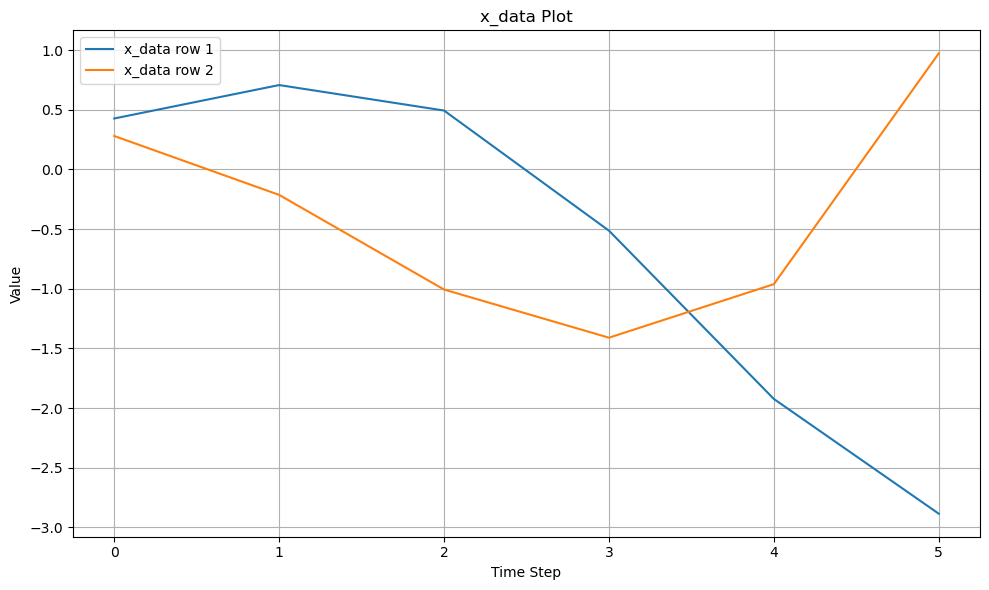

Psi_i.shape(5, 4)
Phi_i.shape:(5, 3)
Pi_i.shape:(5, 2)
Gamma_i：{Gamma_i} 满足秩条件。


KeyboardInterrupt: 

In [41]:

K_i_final = solve_K()
print("最终反馈增益矩阵 K:", K_i_final)



In [42]:
print(np.exp(-20))

2.061153622438558e-09
